In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(precision=4)
import Krylov as K

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


I start by considering the spectral decomposition for an arbitrary matrix (with random elements)

In [2]:
n=4
Hr=np.matrix(np.random.rand(n*n).reshape(n,n))
Hi=np.matrix(np.random.rand(n*n).reshape(n,n))
H = Hr+1*1j*Hi
#H += H.conj().T
u0 = np.matrix(np.random.rand(n).reshape(n,1))
u0norm = K.norm(u0)
u0=u0/u0norm
K.norm(u0)

1.0

In [3]:
H

matrix([[ 0.2182+0.1772j,  0.2734+0.1418j,  0.0352+0.1677j,  0.3731+0.396j ],
        [ 0.4893+0.5644j,  0.7046+0.448j ,  0.9911+0.4989j,  0.5767+0.5807j],
        [ 0.9776+0.4109j,  0.0741+0.8648j,  0.8825+0.3364j,  0.7480+0.8141j],
        [ 0.6834+0.0524j,  0.2443+0.6438j,  0.9803+0.2525j,  0.4634+0.3896j]])

I use eig (and not eigh) and compute eigenvalues and left and right eigenvectors. I sort the eigenvalues and eigenvector in decreasing order

In [4]:
er,vr = np.linalg.eig(H)
es,vl = np.linalg.eig(H.conj().T)
es = es.conj()

ind = er.argsort()[::-1] 
er = er[ind]
vr = vr[:,ind]

ind = es.argsort()[::-1] 
es = es[ind]
vl = vl[:,ind]

def ket(ind):
    k = vr[:,ind]
    return k
def bra(ind):
    b = vl[:,ind].conj().T
    return b

In [5]:
print(er)
print(es)

[ 2.1788+1.8068j  0.3142+0.009j   0.0364-0.4794j -0.2608+0.0147j]
[ 2.1788+1.8068j  0.3142+0.009j   0.0364-0.4794j -0.2608+0.0147j]


I check the meaning of the left and right eigenvalue condition

In [6]:
K.validate_eigensystem(H,er,vr)

Validation terminated


In [8]:
K.validate_eigensystem(H.T,es,vl.conj())

Validation terminated


Using the left and right eigenvector I can write a completeness relation

In [10]:
Id=np.matrix(np.zeros((n*n),dtype=np.complex_).reshape(n,n))
for ind in range(n):
    Id += np.matmul(ket(ind),bra(ind))/K.sp(bra(ind),ket(ind))
np.allclose(Id,np.eye(n),atol=1.e-12)

True

The basis is bi-orthonormal in the sense that

In [11]:
K.sp(bra(0),ket(1))

(-1.1102230246251565e-16-1.2836953722228372e-16j)

I build the spectral decomposition of $H$

In [12]:
M=np.matrix(np.zeros((n*n),dtype=np.complex_).reshape(n,n))
for ind in range(n):
    M += er[ind]*np.matmul(ket(ind),bra(ind))/K.sp(bra(ind),ket(ind))
M
np.allclose(M,H,atol=1.e-12)

True

I compute the resolvent of $H$ by using the spectral representation of $H$
$$ G(z) = \frac{1}{z-H}  = \sum_{n,m} \frac{ | \phi_{n} \rangle \langle \chi_{n} | }{\langle \chi_{n}|\phi_{n}\rangle}\frac{1}{z-H}\frac{| \phi_{m} \rangle \langle \chi_{m}|}{\langle \chi_{m}|\phi_{m}\rangle} = \sum_{n}\frac{| \phi_{n} \rangle \langle \chi_{n}|}{\langle \chi_{n}|\phi_{n}\rangle}\frac{1}{z-E_{n}}
$$
where $|\phi_{n}\rangle$ and $\langle \chi_{n}|$ are the right and left eigenvectors of $H$.

I check for the resolvent condition
$$G(z)(z-H)=1
$$

In [13]:
def Gcheck(omega,eta=1.e-2):
    G=np.matrix(np.zeros((n*n),dtype=np.complex_).reshape(n,n))
    for ind,E in enumerate(er):
        G += np.matmul(ket(ind),bra(ind))/K.sp(bra(ind),ket(ind))*1.0/(omega-E+1j*eta)
    zmH = (omega+1j*eta)*np.eye(n) - H
    GzmH = np.matmul(G,zmH)
    isok = np.allclose(GzmH,np.eye(n),atol=1.e-12)
    return isok

In [14]:
x=np.arange(-2.0, 2.0, 0.01)
for val in x: 
    if not Gcheck(val): print('False resolvent condition')

Now I compute the resolvent of $H$ on $u_{0}$ by using the spectral representation of $H$
$$ G_{0}(z) = \langle u_{0} | \frac{1}{z-H} | u_{0} \rangle = \sum_{n}\frac{\langle u_{0} | \phi_{n} \rangle \langle \chi_{n}|u_{0}\rangle}{\langle \chi_{n}|\phi_{n}\rangle}\frac{1}{z-E_{n}}
$$
where $|\phi_{n}\rangle$ and $\langle \chi_{n}|$ are the right and left eigenvectors of $H$.

In [17]:
def resolvent(omega,eta=1.e-2):
    G = 0.0
    u0bra = u0.conj().T 
    for ind,E in enumerate(er):
        u0dotphin = K.sp(u0bra,ket(ind))
        chindotu0 = K.sp(bra(ind),u0)
        G+=u0dotphin*chindotu0/K.sp(bra(ind),ket(ind))*1.0/(omega-E+1j*eta)
    G = -1/np.pi*G.imag
    return G

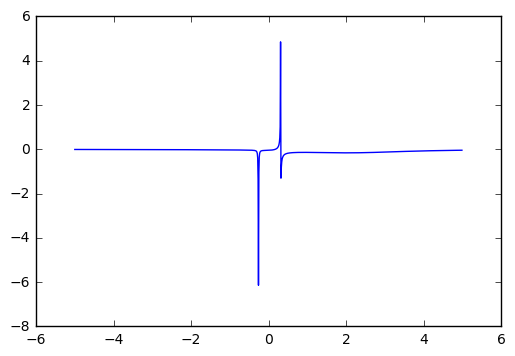

In [18]:
x=np.arange(-5.0, 5.0, 0.01)
plt.plot(x,resolvent(x))

Now I want to reproduce this result using the Lanczos procedure. I build the right and left Krylov spaces $|\phi_{n}\rangle, \langle \chi_{n}|$ generated by the repeated action of $H$ on the given (normalized) right and left vectors $|u_{0}\rangle, \langle u_{0}|$. The elements of the space satisfy the relation:

$$
H|\phi_{n} \rangle = \beta_{n}|\phi_{n-1}\rangle + \alpha_{n}|\phi_{n}\rangle + \beta_{n+1}|\phi_{n+1}\rangle
$$
$$
\langle \chi_{n}|H = \langle \chi_{n-1}|\gamma_{n} + \langle\chi_{n}|\alpha_{n}^{*} + \langle\chi_{n+1}|\gamma_{n+1}
$$

I define the routine that generates the Krylov spaces and computes the coefficients $\alpha$ and $\beta$.
The first step of the procedure $(dimKrylov=1)$ is given by:

$$
|\phi_{0}\rangle = |u_{0}\rangle \; , \quad \alpha_{0} = \langle u_{0}|H|u_{0}\rangle \; , \quad \beta_{0} = 0 \; , \quad
\beta_{1} = ||(H-\alpha_{0})|u_{0}\rangle ||
$$
$$
\langle \chi_{0}| = \langle u_{0}|  \; , \quad \gamma_{0} = 0 \; , \quad
\gamma_{1} = ||\langle u_{0}|(H-\alpha_{0}^{*}) ||
$$

The second step of the procedure $(dimKrylov=2)$ takes $|\phi_{0}\rangle,\langle\chi_{0}|,\alpha_{0},\beta_{1},\gamma_{1},\beta_{0}=\gamma_{0}=0$ as input and returns $|\phi_{1}\rangle,\langle\chi_{1}|,\alpha_{1},\beta_{2},\gamma_{2}$ according to:

$$
|\phi_{1}\rangle = \frac{(H-\alpha_{0})|\phi_{0}\rangle}{\beta_{1}} \; , \quad \langle\chi_{1}| = \frac{\langle\chi_{0}|(H-\alpha_{0}^{*})}{\gamma_{1}} \; , \quad \alpha_{1} = \langle \chi_{1}|H|\phi_{1}\rangle  
$$
$$
\beta_{2} = ||(H-\alpha_{1})|\phi_{1}\rangle-\beta_{1}|\phi_{0}\rangle || \; , \quad
\gamma_{2} = ||\langle\chi_{1}|(H-\alpha_{1}^{*})-\langle\chi_{0}|\gamma_{1} ||
$$

The third step of the procedure $(dimKrylov=3)$ takes $|\phi_{1}\rangle,|\phi_{0}\rangle,\langle\chi_{1}|,\langle\chi_{0}|,\alpha_{1},\beta_{2},\beta_{1},\gamma_{2},\gamma_{1}$ as input and returns $|\phi_{2}\rangle,\langle\chi_{2}|,\alpha_{2},\beta_{3},\gamma_{3}$ according to:

$$
|\phi_{2}\rangle = \frac{(H-\alpha_{1})|\phi_{1}\rangle-\beta_{1}|\phi_{0}\rangle}{\beta_{2}} \; , \quad \langle\chi_{2}| = \frac{\langle\chi_{1}|(H-\alpha_{1}^{*})-\langle\chi_{0}|\gamma_{1}}{\gamma_{2}} \; , \quad \alpha_{2} = \langle \chi_{2}|H|\phi_{2}\rangle  
$$
$$
\beta_{3} = ||(H-\alpha_{2})|\phi_{2}\rangle-\beta_{2}|\phi_{1}\rangle || \; , \quad 
\gamma_{3} = ||\langle\chi_{2}|(H-\alpha_{2}^{*})-\langle\chi_{1}|\gamma_{2}||
$$

The generic step takes $|\phi_{s}\rangle,|\phi_{s-1}\rangle,\langle\chi_{s}|,\langle\chi_{s-1}|,\alpha_{s},\beta_{s+1}\beta_{s},\gamma_{s+1},\gamma_{s}$ as input and gives $|\phi_{s+1}\rangle,\langle\chi_{s+1}|,\alpha_{s+1},\beta_{s+2},\gamma_{s+2}$ according to the formula:

$$
|\phi_{s+1}\rangle = \frac{(H-\alpha_{s})|\phi_{s}\rangle-\beta_{s}|\phi_{s-1}\rangle}{\beta_{s+1}} \; , \quad 
\langle\chi_{s+1}| = \frac{\langle\chi_{s}|(H-\alpha_{s}^{*})-\langle\chi_{s-1}|\gamma_{s}}{\gamma_{s+1}} \; , \quad \alpha_{s+1} = \langle \chi_{s+1}|H|\phi_{s+1}\rangle  
$$
$$
\beta_{s+2} = ||(H-\alpha_{s+1})|\phi_{s+1}\rangle-\beta_{s+1}|\phi_{s}\rangle || \; , \quad 
\gamma_{s+2} = ||\langle\chi_{s+1}|(H-\alpha_{s+1}^{*})-\langle\chi_{s}|\gamma_{s+1}||
$$

In [19]:
def lanc_rec(H,phij,phijm1,chij,chijm1,alphaj,betaj,gammaj):
    phihatjp1 = H.dot(phij)-alphaj*phij-gammaj*phijm1
    chihatjp1 = chij.dot(H)-chij*alphaj.conj()-chijm1*betaj
    betajp1 = norm(phihatjp1)
    gammajp1 = sp(chihatjp1,phihatjp1)/betajp1
    phijp1 = phihatjp1/betajp1
    chijp1=chihatjp1/gammajp1
    alphajp1 = sp(chijp1,H.dot(phijp1))
    
    return phijp1,chijp1,alphajp1,betajp1,gammajp1

I perform the recursion until the Krylov space reaches a given dimension

In [17]:
dimKrylov = 4

# definition and init
alpha=[]
beta=[]
gamma=[]
krylovr = np.matrix(np.zeros((n*dimKrylov),dtype=np.complex_).reshape(n,dimKrylov))
krylovl = np.matrix(np.zeros((n*dimKrylov),dtype=np.complex_).reshape(dimKrylov,n))

krylovr[:,0] = u0
krylovl[0,:] = u0.conj().T
alpha0 =  sp(krylovl[0,:],H.dot(krylovr[:,0]))
alpha.append(alpha0)
beta.append(0)
gamma.append(0)
dimVal = 1 #actual dimension of Krylov space

# first iteration
unot = np.matrix(np.zeros(n).reshape(n,1)) #needed for the first step
bunot = np.matrix(np.zeros(n).reshape(1,n))
phi1,chi1,alpha1,beta1,gamma1=lanc_rec(H,krylovr[:,0],unot,krylovl[0,:],bunot,alpha[-1],beta[-1],gamma[-1])
krylovr[:,dimVal] = phi1
krylovl[dimVal,:] = chi1
alpha.append(alpha1)
beta.append(beta1)
gamma.append(gamma1)
dimVal += 1

# generic iteration
while dimVal < dimKrylov :
    phijp1,chijp1,alphajp1,betajp1,gammajp1=lanc_rec(H,krylovr[:,dimVal-1],krylovr[:,dimVal-2],krylovl[dimVal-1,:],krylovl[dimVal-2,:],alpha[-1],beta[-1],gamma[-1])
    krylovr[:,dimVal] = phijp1
    krylovl[dimVal,:] = chijp1
    alpha.append(alphajp1)
    beta.append(betajp1)
    gamma.append(gammajp1)
    dimVal += 1

In [18]:
krylovr

matrix([[ 0.4201+0.j    ,  0.2035+0.3971j,  0.3488-0.1373j, -0.1129-0.333j ],
        [ 0.5214+0.j    ,  0.4289+0.1068j,  0.0430-0.5944j, -0.4703-0.0229j],
        [ 0.0908+0.j    ,  0.3460+0.3877j,  0.3120-0.2379j, -0.2815-0.3185j],
        [ 0.7372+0.j    , -0.4619-0.3495j, -0.2676+0.528j ,  0.6255+0.2877j]])

In [19]:
krylovl

matrix([[ 0.4201+0.j    ,  0.5214+0.j    ,  0.0908+0.j    ,  0.7372+0.j    ],
        [ 1.0370-0.4991j,  1.3649-0.1894j,  0.6670-0.8029j,  1.1368-0.0907j],
        [ 0.6228+0.8821j,  0.3509+1.092j ,  0.9103+0.6318j,  0.2718+0.6897j],
        [-1.1087+0.838j , -1.3681+0.513j , -0.7783+1.1837j, -0.8526+0.4251j]])

In [20]:
print(alpha)
print(beta)
print(gamma)

[(1.3091068902593945+1.5146815598443952j), (0.071610652599914754+3.5810930917389112j), (0.5927951643723427+2.7058655855734566j), (0.40747388442867777+3.0819897800819178j)]
[0, (1.0272944713205099+0j), (3.290554447456532+0j), (9.1027918136736155+0j)]
[0, (-0.30954391972453565+1.4129094042493036j), (6.5675820849603337-0.024560703105589617j), (6.6429904591037214+0.088647719869131544j)]


I compute $H$ in the basis of the krylov vectors and verify if it is a tridiagonal matrix $T$ with elements given by
$\alpha,\beta,\gamma$ parameters.

In [21]:
Hkrylov = np.matmul(krylovl,np.matmul(H,krylovr))
print(Hkrylov)

[[ 1.3091+1.5147j -0.3095+1.4129j  1.3008+0.285j   0.3568-1.0902j]
 [ 4.3845+2.5121j  0.0716+3.5811j  3.2707-0.0905j  0.2707-2.8545j]
 [-1.3322+4.1935j -2.9676+0.6255j  0.5928+2.7059j  2.4217-0.2043j]
 [-5.4582-1.469j  -0.9810-3.7568j -3.4253+0.9228j  0.4075+3.082j ]]


In [22]:
Up = np.matrix(np.zeros(dimKrylov**2,dtype=np.complex_).reshape(dimKrylov,dimKrylov))
Down = np.matrix(np.zeros(dimKrylov**2,dtype=np.complex_).reshape(dimKrylov,dimKrylov))
T = np.matrix(np.diag(alpha))
for i in range(dimKrylov-1):
    Up[i,i+1] = gamma[i+1]
    Down[i+1,i] = beta[i+1]
T += Up + Down
T

matrix([[ 1.3091+1.5147j, -0.3095+1.4129j,  0.0000+0.j    ,  0.0000+0.j    ],
        [ 1.0273+0.j    ,  0.0716+3.5811j,  6.5676-0.0246j,  0.0000+0.j    ],
        [ 0.0000+0.j    ,  3.2906+0.j    ,  0.5928+2.7059j,  6.6430+0.0886j],
        [ 0.0000+0.j    ,  0.0000+0.j    ,  9.1028+0.j    ,  0.4075+3.082j ]])

In [23]:
np.allclose(Hkrylov,T,atol=1.e-10)

False